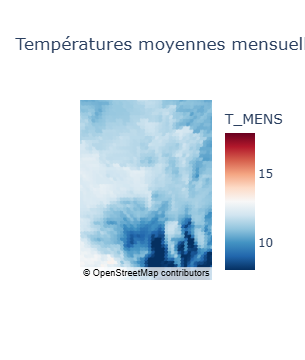

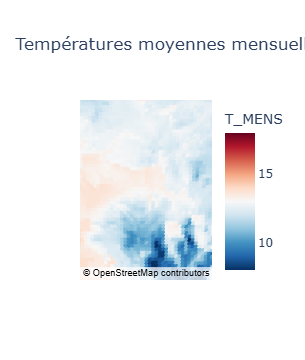

In [9]:
import warnings
# pour avoir un rendu clean
warnings.filterwarnings("ignore")

import pandas as pd
import plotly.express as px
from pyproj import Transformer
import requests
from utils import DATAGOUV_URL

annee_debut = 1959
annee_fin = 2023
# On définit une échelle fiixe
temp_min = 8
temp_max = 18

liste_tableaux = []

# on request L'API
response = requests.get(DATAGOUV_URL + "api/1/datasets/65e040c50a5c6872ebebc711/")
contenu_api = response.json()
resources = contenu_api["resources"]

# On garde uniquement les fichiers principaux
fichiers_a_traiter = [r for r in resources if r["type"] == "main"]

for fichier in fichiers_a_traiter:
    lien = fichier["url"]
    try:
        # en gzip
        df = pd.read_csv(lien, sep=";", compression='gzip')
        
        # pour extraire juste l'année
        df['annee'] = df['DATE'].astype(str).str[:4].astype(int)
        df_filtre = df[df['annee'].isin([annee_debut, annee_fin])].copy()
        
        if not df_filtre.empty:
            liste_tableaux.append(df_filtre)
    except:
        
        continue

#CONSTRUIRE LA CARTE
if len(liste_tableaux) > 0:
    df_global = pd.concat(liste_tableaux)
    
    # Conversion des coordonnées Lambert (utilisées par Météo France) vers GPS (Latitude/Longitude)
    # C'est nécessaire pour l'affichage sur la carte
    convertisseur = Transformer.from_crs("EPSG:27572", "EPSG:4326", always_xy=True)
    lon, lat = convertisseur.transform(df_global['LAMBX'] * 100, df_global['LAMBY'] * 100)
    
    df_global['latitude'] = lat
    df_global['longitude'] = lon
    
    # On fait la moyenne des températures par station pour chaque année
    df_carte = df_global.groupby(['annee', 'latitude', 'longitude'])['T_MENS'].mean().reset_index()
    
    # Carte 1 
    donnees_debut = df_carte[df_carte['annee'] == annee_debut]
    
    fig1 = px.scatter_mapbox(
        donnees_debut, 
        lat="latitude", 
        lon="longitude", 
        color="T_MENS", 
        color_continuous_scale="RdBu_r", # Échelle Rouge-Bleu inversée (Rouge = Chaud)
        range_color=[temp_min, temp_max], # On force l'échelle définie au début
        zoom=4.5, 
        center={"lat": 46.7, "lon": 2.5}, # Centré sur la France
        mapbox_style="open-street-map",
        title=f"Températures moyennes mensuelles - Année {annee_debut}"
    )
    fig1.show()

    # Carte 2
    donnees_fin = df_carte[df_carte['annee'] == annee_fin]
    
    fig2 = px.scatter_mapbox(
        donnees_fin, 
        lat="latitude", 
        lon="longitude", 
        color="T_MENS", 
        color_continuous_scale="RdBu_r", 
        range_color=[temp_min, temp_max], # Même échelle pour bien comparer
        zoom=4.5, 
        center={"lat": 46.7, "lon": 2.5},
        mapbox_style="open-street-map",
        title=f"Températures moyennes mensuelles - Année {annee_fin}"
    )
    fig2.show()
    
else:
    print(" Aucune donnée.")

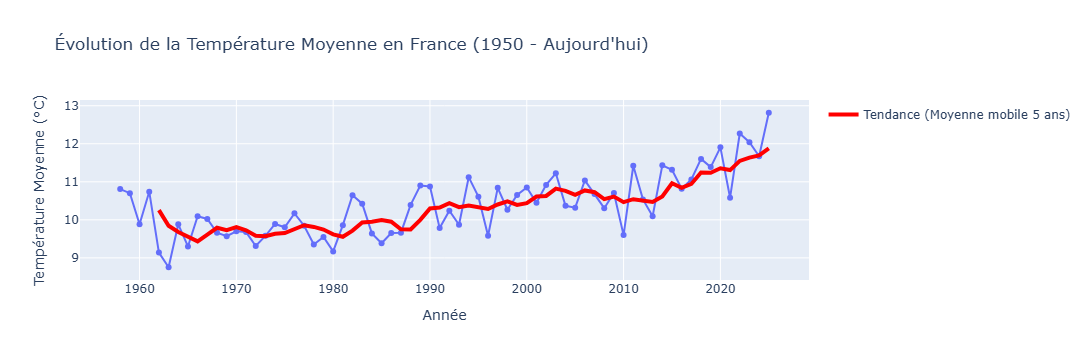

In [28]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import requests
import plotly.express as px
from utils import DATAGOUV_URL

response = requests.get(DATAGOUV_URL + "api/1/datasets/65e040c50a5c6872ebebc711/")
resources = response.json()["resources"]

fichiers_donnees = [r for r in resources if r["type"] == "main"]

resultats_annuels = []

for ressource in fichiers_donnees:
    try:
        df = pd.read_csv(ressource["url"], sep=";", compression='gzip')
        df['annee'] = df['DATE'].astype(str).str.slice(0, 4).astype(int)
        moyennes = df.groupby('annee')['T_MENS'].mean().reset_index()
        resultats_annuels.append(moyennes)
    except:
        continue

if len(resultats_annuels) > 0:
    df_total = pd.concat(resultats_annuels).sort_values("annee")
    df_total['tendance_lissee'] = df_total['T_MENS'].rolling(5).mean()

    fig = px.line(
        df_total, 
        x="annee", 
        y="T_MENS",
        title="Évolution de la Température Moyenne en France (1950 - Aujourd'hui)",
        labels={"T_MENS": "Température Moyenne (°C)", "annee": "Année"},
        markers=True
    )
    
    fig.add_scatter(
        x=df_total['annee'], 
        y=df_total['tendance_lissee'],
        mode='lines', 
        name='Tendance (Moyenne mobile 5 ans)', 
        line=dict(color='red', width=4)
    )

    fig.show()

In [29]:
import pandas as pd

url_ademe = "https://data.ademe.fr/data-fair/api/v1/datasets/igt-pouvoir-de-rechauffement-global/convert"

try:
    df = pd.read_csv(url_ademe, nrows=5)
    print("\n LES COLONNES DISPONIBLES")
    for col in df.columns:
        print(f" {col}")
        
    display(df.head(3))

except Exception as e:
    print(f"Erreur de lecture : {e}")


 LES COLONNES DISPONIBLES
 INSEE commune
 Commune
 Agriculture
 Autres transports
 Autres transports international
 CO2 biomasse hors-total
 Déchets
 Energie
 Industrie hors-énergie
 Résidentiel
 Routier
 Tertiaire


,INSEE commune,Commune,Agriculture,Autres transports,Autres transports international,CO2 biomasse hors-total,Déchets,Energie,Industrie hors-énergie,Résidentiel,Routier,Tertiaire
0,1001,L'ABERGEMENT-CLEMENCIAT,3711.425991,NaN,NaN,432.751835,101.430476,2.354558,6.911213,309.358195,793.156501,367.036172
1,1002,L'ABERGEMENT-DE-VAREY,475.330205,NaN,NaN,140.741660,140.675439,2.354558,6.911213,104.866444,348.997893,112.934207
2,1004,AMBERIEU-EN-BUGEY,499.043526,212.577908,NaN,10313.446515,5314.314445,998.332482,2930.354461,16616.822534,15642.420313,10732.376934
